# BUAN 6341.002 - Applied Machine Learning
# Project 1


## Professor : Nassim Sohaee


### Submitted by :
### Prem Kumar Pulluri


## Part 2 Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from feature_engine.discretisers import EqualWidthDiscretiser
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn import metrics
from feature_engine import missing_data_imputers as mdi
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [2]:
df = pd.read_csv('bank_final_new.csv')

In [ ]:
"""
Input variables:
    bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
    related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12 - duration: last contact duration, in seconds (numeric)
    other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")
 """

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,46.0,admin.,married,secondary,no,0.0,yes,no,cellular,8.0,sep,149.0,2.0,187.0,1.0,failure,no
1,55.0,NaN,married,secondary,no,NaN,no,no,cellular,6.0,feb,354.0,5.0,-1.0,0.0,unknown,no
2,39.0,blue-collar,divorced,unknown,no,170.0,yes,no,unknown,6.0,may,268.0,NaN,-1.0,0.0,unknown,no
3,48.0,management,single,tertiary,no,906.0,yes,no,telephone,29.0,jul,289.0,9.0,NaN,0.0,unknown,no
4,38.0,technician,married,secondary,no,-104.0,no,no,cellular,28.0,aug,13.0,17.0,-1.0,0.0,unknown,no


In [4]:
df.y.value_counts() # Dataset looks balanced

yes    1716
no     1632
Name: y, dtype: int64

### Check for null values

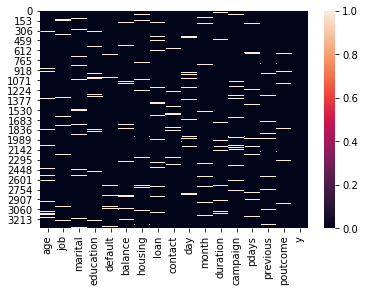

In [5]:
sns.heatmap(df.isnull(),)

### Drop unnecessary columns

In [6]:
df.drop(['day', 'month', 'contact', 'pdays', 'previous', 'poutcome'], axis=1, inplace=True)

### Drop rows where target variable has null values

In [7]:
df.dropna(subset=['y'], inplace=True)

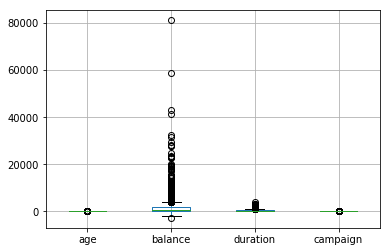

In [8]:
# Checking to see outliers
df.boxplot()

In [9]:
df.y = df.y.map(dict(yes=1, no=0))

In [10]:
X = df.drop(['y'], axis=1)

In [11]:
y = df[['y']]

In [12]:
X_train_og, X_test_og, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [13]:
bank_pipe = Pipeline([

    # missing data imputation pipeline

    ('imputer_num_mean',
     mdi.MeanMedianImputer(imputation_method='mean',variables=['age'])),
    
    ('imputer_num_mean2',
     mdi.MeanMedianImputer(imputation_method='mean',variables=['duration'])),
    
    ('imputer_num_mean3',
     mdi.MeanMedianImputer(imputation_method='mean',variables=['campaign'])),
    
    ('imputer_num_mean4',
     mdi.MeanMedianImputer(imputation_method='mean',variables=['balance'])),
    
    ('imputer_cat_missing',
     mdi.CategoricalVariableImputer(variables=['job','marital', 'education', 'default'
                                              , 'housing', 'loan'])),
    
    # Variables to encode
    ('categorical_encoder',
     OneHotCategoricalEncoder( top_categories=None,
                               variables=['job','marital', 'education', 'default'
                                        , 'housing', 'loan'],
                               drop_last=True)),
    
])

In [14]:
bank_pipe.fit(X_train_og, y_train)

Pipeline(memory=None,
     steps=[('imputer_num_mean', MeanMedianImputer(imputation_method='mean', variables=['age'])), ('imputer_num_mean2', MeanMedianImputer(imputation_method='mean', variables=['duration'])), ('imputer_num_mean3', MeanMedianImputer(imputation_method='mean', variables=['campaign'])), ('imputer_num_mean4', M...gories=None,
             variables=['job', 'marital', 'education', 'default', 'housing', 'loan']))])

In [15]:
X_train_imputed = bank_pipe.transform(X_train_og)
X_test_imputed = bank_pipe.transform(X_test_og)

In [16]:
X_train_imputed.age = pd.cut(X_train_imputed.age, bins=10)
X_test_imputed.age = pd.cut(X_test_imputed.age, bins=10)

In [17]:
X_train_imputed.balance = pd.cut(X_train_imputed.balance, bins=5)
X_test_imputed.balance = pd.cut(X_test_imputed.balance, bins=5)

In [18]:
X_train_imputed.duration = pd.cut(X_train_imputed.duration, bins=5)
X_test_imputed.duration = pd.cut(X_test_imputed.duration, bins=5)

In [19]:
X_train_imputed = pd.get_dummies(X_train_imputed, columns=['age', 'balance', 'duration'])
X_test_imputed = pd.get_dummies(X_test_imputed, columns=['age', 'balance', 'duration'])

In [20]:
scaler = RobustScaler()
scaler.fit(X_train_imputed)
X_train = scaler.transform(X_train_imputed)
X_test = scaler.transform(X_test_imputed)

In [21]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

## Various Classification Techniques

### Kernelized SVM Classifier

In [22]:
from sklearn.svm import SVC
svc = SVC()
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['poly'],
               'degree': [2, 3, 4, 5, 6]}]
svm_grid = GridSearchCV(svc, param_grid, cv=5,return_train_score=True,scoring='accuracy')
svm_grid.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(svm_grid.best_score_), end='\n\n')

#find best parameters
print('Kernelized SVM Best parameters: ',svm_grid.best_params_, end='\n\n')

#Check test data set performance
print("Kernelized SVM Train Performance: ",svm_grid.score(X_train,y_train))
print("Kernelized SVM Test Performance: ",svm_grid.score(X_test,y_test), end='\n\n')


prediction = svm_grid.predict(X_test)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
print("F1 score:",metrics.f1_score(prediction,y_test))
print("Precision:",metrics.precision_score(prediction,y_test))
print("Recall:",metrics.recall_score(prediction,y_test))
print("ROC_AUC:",metrics.roc_auc_score(prediction,y_test))
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction, y_test))

D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

Best Mean Cross-validation score: 0.69

Kernelized SVM Best parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Kernelized SVM Train Performance:  0.7230046948356808
Kernelized SVM Test Performance:  0.700497512437811

Accuracy: 0.700497512437811
F1 score: 0.6980942828485457
Precision: 0.7160493827160493
Recall: 0.6810176125244618
ROC_AUC: 0.700832692901907
Confusion Matrix:
 [[356 138]
 [163 348]]


### Linear SVM Classifier

In [27]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

svc = LinearSVC()
param_grid = {'C':np.arange(0.01,100,10)}
svm_grid = GridSearchCV(svc,param_grid,cv=5,return_train_score=True)
svm_grid.fit(X_train,y_train)

print("Best Mean Cross-validation score: {:.2f}".format(svm_grid.best_score_), end='\n\n')

#find best parameters
print('Linear SVM Best parameters: ',svm_grid.best_params_, end='\n\n')

#Check test data set performance
print("Linear SVM Train Performance: ",svm_grid.score(X_train,y_train))
print("Linear SVM Test Performance: ",svm_grid.score(X_test,y_test), end='\n\n')

#Metrics
prediction = svm_grid.predict(X_test)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
print("F1 score:",metrics.f1_score(prediction,y_test))
print("Precision:",metrics.precision_score(prediction,y_test))
print("Recall:",metrics.recall_score(prediction,y_test))
print("ROC_AUC:",metrics.roc_auc_score(prediction,y_test))
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction, y_test))

D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best Mean Cross-validation score: 0.69

Linear SVM Best parameters:  {'C': 0.01}

Linear SVM Train Performance:  0.7050789586000854
Linear SVM Test Performance:  0.681592039800995

Accuracy: 0.681592039800995
F1 score: 0.6923076923076922
Precision: 0.7407407407407407
Recall: 0.6498194945848376
ROC_AUC: 0.6852201685784499
Confusion Matrix:
 [[325 126]
 [194 360]]


### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

clf = LogisticRegression()
params = {'penalty':['l2'],'dual':[False],'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'fit_intercept':[True,False],
        'solver':['saga','newton-cg', 'lbfgs', 'liblinear', 'sag']}
gridlog = GridSearchCV(clf, params, cv=5, n_jobs=2, scoring='accuracy')
gridlog.fit(X_train, y_train)

cv_scores = cross_val_score(gridlog, X_train, y_train)

#Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(cv_scores.mean()), end='\n\n')

#find best parameters
print('Best Logistic Regression parameters: ',gridlog.best_params_, end='\n\n')


#Check test data set performance
print("Logistic Regression Train Performance: ",gridlog.score(X_train,y_train))
print("Logistic Regression Test Performance: ",gridlog.score(X_test,y_test), end='\n\n')


#Metrics
prediction = gridlog.predict(X_test)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
print("F1 score:",metrics.f1_score(prediction,y_test))
print("Precision:",metrics.precision_score(prediction,y_test))
print("Recall:",metrics.recall_score(prediction,y_test))
print("ROC_AUC:",metrics.roc_auc_score(prediction,y_test))
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction, y_test))

D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Cross-validation scores: 0.6862996158770805

Best Logistic Regression parameters:  {'C': 100, 'dual': False, 'fit_intercept': False, 'penalty': 'l2', 'solver': 'saga'}

Logistic Regression Train Performance:  0.704225352112676
Logistic Regression Test Performance:  0.6885572139303483

Accuracy: 0.6885572139303483
F1 score: 0.7004784688995216
Precision: 0.7530864197530864
Recall: 0.6547406082289803
ROC_AUC: 0.6928411561324274
Confusion Matrix:
 [[326 120]
 [193 366]]


D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### KNN Classifier

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# define a list of parameters

param_knn = {'n_neighbors': range(5,25), 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
            'weights':['uniform','distance']}

#apply grid search
grid_knn = GridSearchCV(knn, param_knn, cv=5, return_train_score=True, scoring='accuracy')
grid_knn.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_knn.best_score_), end='\n\n')

#find best parameters
print('KNN Best parameters: ',gridlog.best_params_, end='\n\n')

#Check test data set performance
print("KNN Train Performance: ",grid_knn.score(X_train,y_train))
print("KNN Test Performance: ",grid_knn.score(X_test,y_test), end='\n\n')

#Metrics
prediction = grid_knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
print("F1 score:",metrics.f1_score(prediction,y_test))
print("Precision:",metrics.precision_score(prediction,y_test))
print("Recall:",metrics.recall_score(prediction,y_test))
print("ROC_AUC:",metrics.roc_auc_score(prediction,y_test))
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction, y_test))

Best Mean Cross-validation score: 0.67

KNN Best parameters:  {'C': 100, 'dual': False, 'fit_intercept': False, 'penalty': 'l2', 'solver': 'saga'}

KNN Train Performance:  0.6991037131882202
KNN Test Performance:  0.6517412935323383

Accuracy: 0.6517412935323383
F1 score: 0.6568627450980391
Precision: 0.6893004115226338
Recall: 0.6273408239700374
ROC_AUC: 0.6533731720699444
Confusion Matrix:
 [[320 151]
 [199 335]]


### Decision Tree Classifier

In [26]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)


param_dtree = {"max_depth": range(1,10),
           "min_samples_split": range(2,10,1),
           "max_leaf_nodes": range(2,5),
           "criterion":['gini','entropy'],
           "splitter":['best','random']}

#apply grid search
grid_dtree = GridSearchCV(dtree, param_dtree, cv=5, return_train_score = True, scoring='accuracy')
grid_dtree.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_dtree.best_score_), end='\n\n')

#find best parameters
print('Decision Tree Best parameters: ',grid_dtree.best_params_, end='\n\n')

#Check test data set performance
print("Decision Tree Train Performance: ",grid_dtree.score(X_train,y_train))
print("Decision Tree Test Performance: ",grid_dtree.score(X_test,y_test), end='\n\n')

#Metrics
prediction = grid_dtree.predict(X_test)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
print("F1 score:",metrics.f1_score(prediction,y_test))
print("Precision:",metrics.precision_score(prediction,y_test))
print("Recall:",metrics.recall_score(prediction,y_test))
print("ROC_AUC:",metrics.roc_auc_score(prediction,y_test))
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction, y_test))

Best Mean Cross-validation score: 0.68

Decision Tree Best parameters:  {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_split': 2, 'splitter': 'best'}

Decision Tree Train Performance:  0.6756295347844644
Decision Tree Test Performance:  0.6885572139303483

Accuracy: 0.6885572139303483
F1 score: 0.6601520086862107
Precision: 0.6255144032921811
Recall: 0.6988505747126437
ROC_AUC: 0.6897761645493042
Confusion Matrix:
 [[388 182]
 [131 304]]


In [3]:
cls_report = pd.DataFrame(index = '0 1 2 3 4'.split(), columns='ModelName TrainScore TestScore Accuracy CVScore'.split())


cls_report['ModelName']['0'] = 'Kernelized SVM Classifier'
cls_report['TrainScore']['0'] = 0.72
cls_report['TestScore']['0'] = 0.70
cls_report['Accuracy']['0'] = 0.70
cls_report['CVScore']['0'] = 0.69

cls_report['ModelName']['1'] = 'Linear SVM Classifier'
cls_report['TrainScore']['1'] = 0.70
cls_report['TestScore']['1'] = 0.68
cls_report['Accuracy']['1'] = 0.68
cls_report['CVScore']['1'] = 0.69


cls_report['ModelName']['2'] = 'Logistic Regression'
cls_report['TrainScore']['2'] = 0.70
cls_report['TestScore']['2'] = 0.68
cls_report['Accuracy']['2'] = 0.68
cls_report['CVScore']['2'] = 0.68

cls_report['ModelName']['3'] = 'KNN Classifier'
cls_report['TrainScore']['3'] = 0.69
cls_report['TestScore']['3'] = 0.65
cls_report['Accuracy']['3'] = 0.65
cls_report['CVScore']['3'] = 0.67

cls_report['ModelName']['4'] = 'Decision Tree Classifier'
cls_report['TrainScore']['4'] = 0.67
cls_report['TestScore']['4'] = 0.68
cls_report['Accuracy']['4'] = 0.68
cls_report['CVScore']['4'] = 0.68



cls_report

,ModelName,TrainScore,TestScore,Accuracy,CVScore
0,Kernelized SVM Classifier,0.72,0.7,0.7,0.69
1,Linear SVM Classifier,0.7,0.68,0.68,0.69
2,Logistic Regression,0.7,0.68,0.68,0.68
3,KNN Classifier,0.69,0.65,0.65,0.67
4,Decision Tree Classifier,0.67,0.68,0.68,0.68


## After comparing all the Classification models based on its train and test scores, we can conclude that Kernelized SVM is the best classifier for this dataset

## Conclusion: 
## The best Classifier is Kernelized SVM with {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}